#                                                            Final Project

#### The data challenge is available:  https://zindi.africa/competitions/digital-green-crop-yield-estimate-challenge
#### My GitHub link is available: https://github.com/lzheng01/Digital-Green-Crop-Yield-Estimate-Project

#### Digital Green Crop Yield Estimate Challenge is to create a machine learning solution to predict the crop yield per acre of rice or wheat crops in Indian. Digital Green, which is a global development organization that empowers smallholder framers to lift themselves out of poverty by harnessing the collective power of technology and grassroots-level partnerships, collected the data via surveys that conducted in multiple distinct in India and shared the data for the data challenge.

#### This notebook will review the dataset and explore some machine learning techniques to predict the yields per acre.


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score

## Exploratory Data Analysis (EDA)

In [4]:
# Read in datasets
train = pd.read_csv("/Users/liyunzheng/Desktop/5509 Final Project/Train.csv")
test  = pd.read_csv("/Users/liyunzheng/Desktop/5509 Final Project/Test.csv")

#The contest provided the train and test datasets seperately in a 75:25 ratio, but I would like to combine them together and then randomly 
#split the data to train and test after the exploratory analysis complete.
df = pd.concat([train, test], ignore_index=True)

# Print out the data columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  5160 non-null   object 
 1   District                            5160 non-null   object 
 2   Block                               5160 non-null   object 
 3   CultLand                            5160 non-null   int64  
 4   CropCultLand                        5160 non-null   int64  
 5   LandPreparationMethod               5160 non-null   object 
 6   CropTillageDate                     5160 non-null   object 
 7   CropTillageDepth                    5160 non-null   int64  
 8   CropEstMethod                       5160 non-null   object 
 9   RcNursEstDate                       5034 non-null   object 
 10  SeedingSowingTransplanting          5160 non-null   object 
 11  SeedlingsPerPit                     4768 no

In [6]:
#  Drop the ID, Dates and Categorical variables from the dataset, and focus on the continuous variables
df_num = df.drop(columns=['ID', 'CropTillageDate', 'RcNursEstDate', 'Harv_date', 'Threshing_date', 'District', 'Block', 'LandPreparationMethod',
                                'CropEstMethod', 'SeedingSowingTransplanting','NursDetFactor', 'TransDetFactor', 'TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource',
                                'OrgFertilizers', 'PCropSolidOrgFertAppMethod', 'CropbasalFerts', 'MineralFertAppMethod', 'CropbasalFerts',
                                'MineralFertAppMethod', 'FirstTopDressFert', 'MineralFertAppMethod.1', 'Harv_method', 'Threshing_method','Stubble_use'])
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CultLand                      5160 non-null   int64  
 1   CropCultLand                  5160 non-null   int64  
 2   CropTillageDepth              5160 non-null   int64  
 3   SeedlingsPerPit               4768 non-null   float64
 4   TransplantingIrrigationHours  4890 non-null   float64
 5   TransIrriCost                 3961 non-null   float64
 6   StandingWater                 4843 non-null   float64
 7   Ganaura                       1948 non-null   float64
 8   CropOrgFYM                    1618 non-null   float64
 9   NoFertilizerAppln             5160 non-null   int64  
 10  BasalDAP                      4426 non-null   float64
 11  BasalUrea                     2885 non-null   float64
 12  tdUrea1                       4427 non-null   float64
 13  app

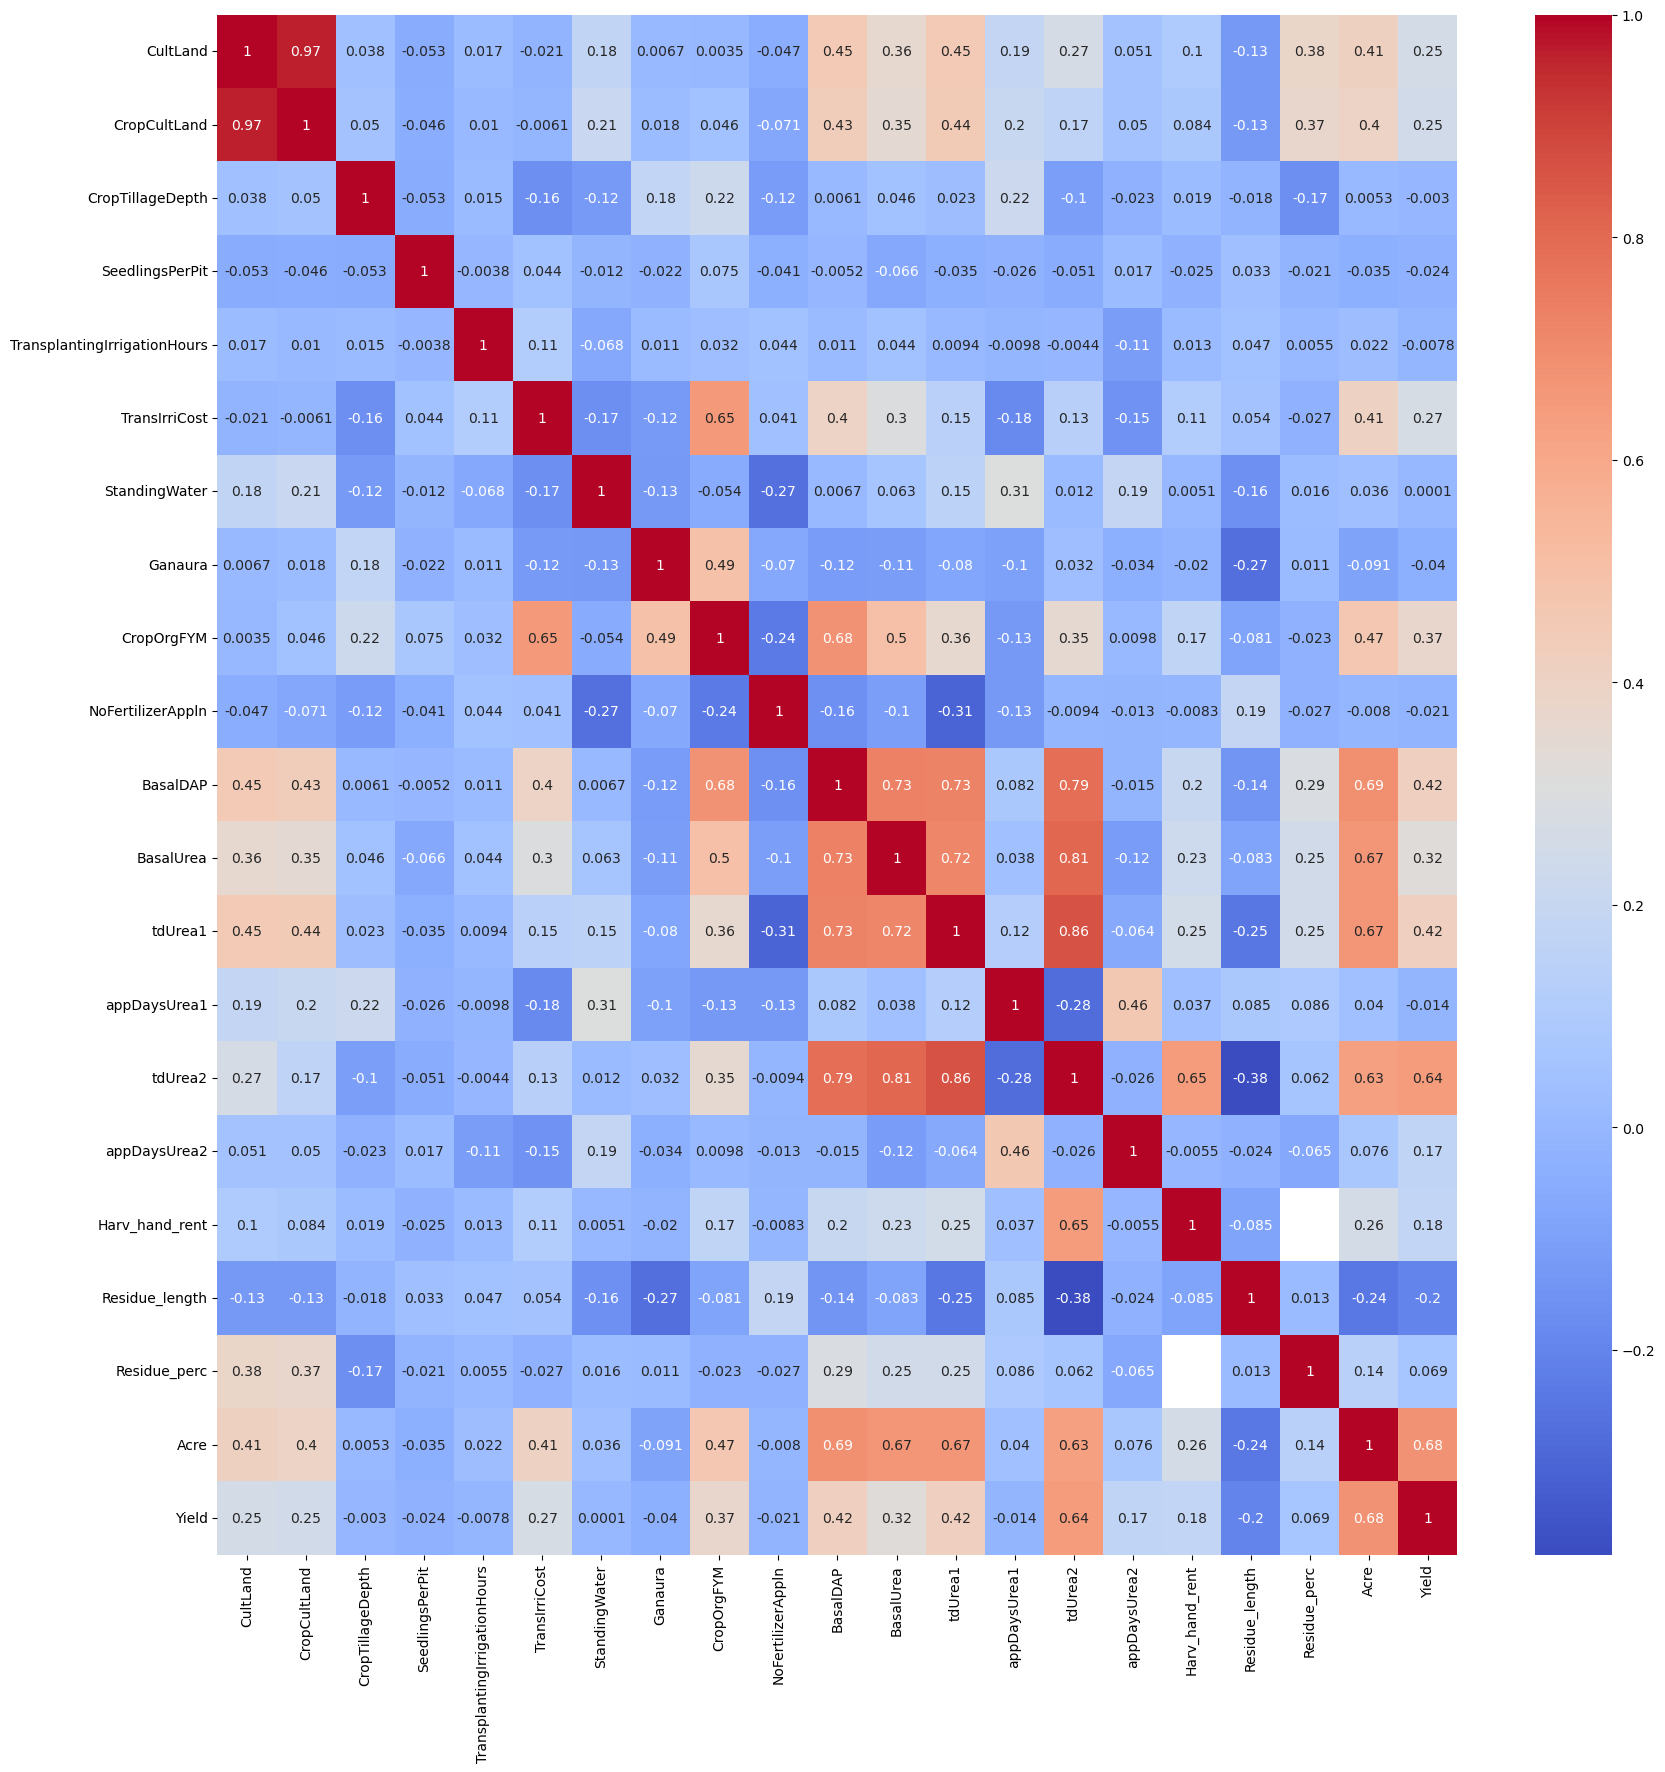

In [12]:
# Visualizing the correlation matrix using a heatmap
corr_matrix = df_num.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Correlation coefficients whose magnitude are between 0.7 and 0.9 indicate variables which can be considered highly correlated. The amount of DAP applied during land preparation (BasalDAP) is highly correlated with the amount of urea applied ('BasalUrea', '1tdUrea', '2tdUrea',). Therefore, only the amount of DAP applied is kept in the analysis; 
### The Area of total cultivated land (Cultrland) is highly correlated with the area of land under cultivation (CropCulturland), So only the area of land under cultivation is kept in the analysis.

In [14]:
#  Drop the highly correlated variables BasalUrea', 'tdUrea1', 'tdUrea2', 'CultLand' from the dataset
df_num2 = df_num.drop(columns=['BasalUrea', 'tdUrea1', 'tdUrea2', 'CultLand'])

# Imputing the NAs values as Zero
na_columns = df_num2.columns[df_num2.isna().any()].tolist()
na_columns.pop()

for column in na_columns:
    if pd.api.types.is_numeric_dtype(df_num2[column]):
        df_num2[column] = df_num2[column].fillna(0)
df_num2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CropCultLand                  5160 non-null   int64  
 1   CropTillageDepth              5160 non-null   int64  
 2   SeedlingsPerPit               5160 non-null   float64
 3   TransplantingIrrigationHours  5160 non-null   float64
 4   TransIrriCost                 5160 non-null   float64
 5   StandingWater                 5160 non-null   float64
 6   Ganaura                       5160 non-null   float64
 7   CropOrgFYM                    5160 non-null   float64
 8   NoFertilizerAppln             5160 non-null   int64  
 9   BasalDAP                      5160 non-null   float64
 10  appDaysUrea1                  5160 non-null   float64
 11  appDaysUrea2                  5160 non-null   float64
 12  Harv_hand_rent                5160 non-null   float64
 13  Res

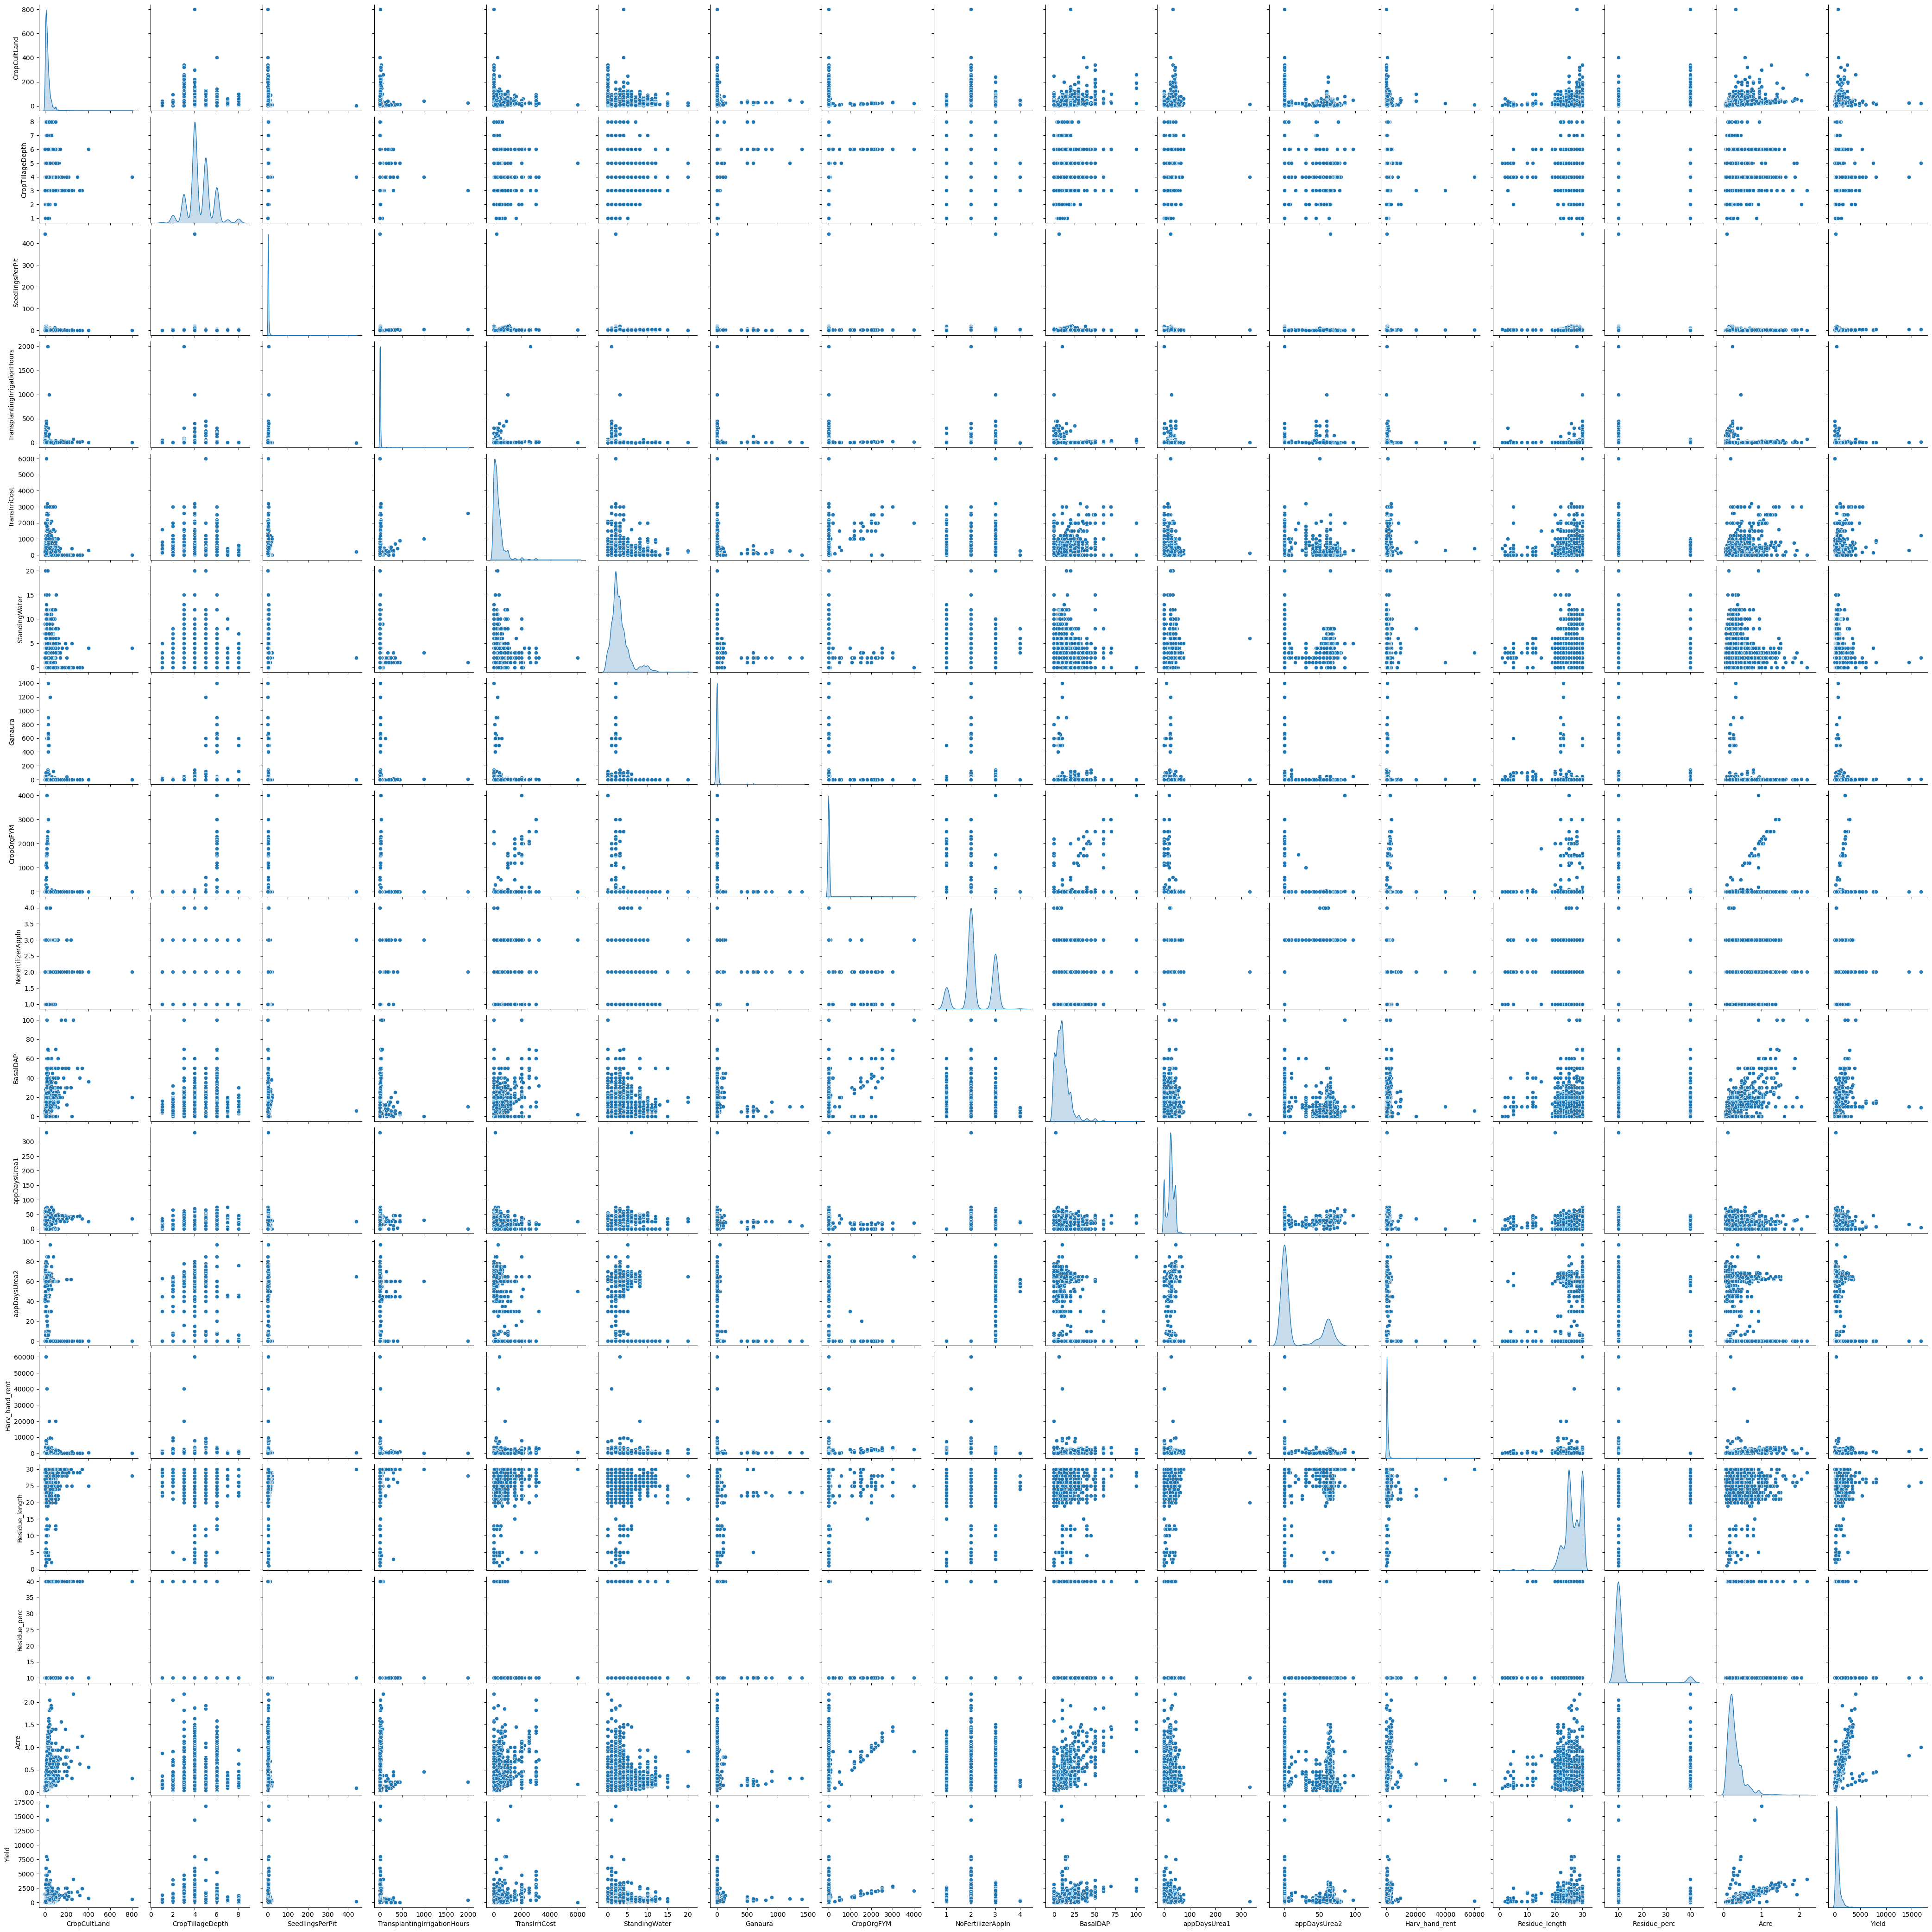

In [16]:
# Inspecting the relationships between variables using a pair plot. 
pair_plot = df_num2.columns[:17]
sns.pairplot(df_num2[pair_plot], diag_kind='kde')
plt.show()

In [18]:
# Yield is the outcome variables. The records with missing yield value have been removed from the dataset.
df_num3 = df_num2[df_num2['Yield'].notna()].copy()
# Based on the pair plot above, the distribution of Yield is left skewed, so apply a log transformation to the Yield variable
df_num3.loc[:, 'Yield'] = np.log1p(df_num3['Yield'])

### Linear Regression Analysis

In [20]:
#Conduct a simple linear regression to check the best predictor for Yield 
best = ['',0]
for p in df_num2.columns.drop('Yield'):
    model  = smf.ols(formula='Yield~'+ p, data=df_num2).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Best predictor:',best)

CropCultLand 0.060625009612561676
CropTillageDepth 8.721627215657612e-06
SeedlingsPerPit 0.00040822370667292773
TransplantingIrrigationHours 5.5437987670714506e-05
TransIrriCost 0.06657726729731173
StandingWater 0.0003703718173786452
Ganaura 0.00031362546337876385
CropOrgFYM 0.0285919649588241
NoFertilizerAppln 0.0004286587692943211
BasalDAP 0.1346373831419605
appDaysUrea1 0.0005327263575787278
appDaysUrea2 0.0010884810293663172
Harv_hand_rent 0.028848132258395776
Residue_length 0.04173581457514264
Residue_perc 0.004703054809447993
Acre 0.45772481643174445
Best predictor: ['Acre', 0.45772481643174445]


In [22]:
# Of course, the yield increases when the area of land under cultivation is larger. Therefore, the Acre should be the best predictor of Yield for sure.
# The new variable Yields per Acre should be derived to investigate other predictors.
df_num3['Yieldacre'] = df_num3['Yield'] / df_num3['Acre'] 
df_num4 = df_num3.drop(columns=['Yield', 'Acre'])

In [24]:
#Conduct the second simple linear regression to check the best predictor for Yield per Acre
best = ['',0]
for p in df_num4.columns.drop('Yieldacre'):
    model  = smf.ols(formula='Yieldacre~'+ p, data=df_num4).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Best predictor for Yields per Arce:',best)

CropCultLand 0.11556321627996213
CropTillageDepth 0.0008092457470252334
SeedlingsPerPit 0.0003641921293225936
TransplantingIrrigationHours 0.0035925882876859383
TransIrriCost 0.04702751053310894
StandingWater 0.0025767317406483192
Ganaura 0.00013439954794536302
CropOrgFYM 0.011537154650884562
NoFertilizerAppln 0.003205699125883754
BasalDAP 0.1463245798113697
appDaysUrea1 0.00024143449713431853
appDaysUrea2 0.016584435074362358
Harv_hand_rent 0.022499172306034043
Residue_length 0.042780602703731185
Residue_perc 0.012244378335407924
Best predictor for Yields per Arce: ['BasalDAP', 0.1463245798113697]


In [26]:
# Split the dataset into train and test datasets
train, test = train_test_split(df_num4, test_size=0.4, random_state=8)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2322 entries, 3791 to 451
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CropCultLand                  2322 non-null   int64  
 1   CropTillageDepth              2322 non-null   int64  
 2   SeedlingsPerPit               2322 non-null   float64
 3   TransplantingIrrigationHours  2322 non-null   float64
 4   TransIrriCost                 2322 non-null   float64
 5   StandingWater                 2322 non-null   float64
 6   Ganaura                       2322 non-null   float64
 7   CropOrgFYM                    2322 non-null   float64
 8   NoFertilizerAppln             2322 non-null   int64  
 9   BasalDAP                      2322 non-null   float64
 10  appDaysUrea1                  2322 non-null   float64
 11  appDaysUrea2                  2322 non-null   float64
 12  Harv_hand_rent                2322 non-null   float64
 13  Residu

In [28]:
best = ['',0]
for p in df_num4.columns.drop('Yieldacre'):
    model  = smf.ols(formula='Yieldacre ~ +BasalDAP+'+ p, data=df_num4).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Second best predictor for Yields per Arce:',best)

CropCultLand 0.19477302869347346
CropTillageDepth 0.14694128155105224
SeedlingsPerPit 0.1465902760328378
TransplantingIrrigationHours 0.14923547856364872
TransIrriCost 0.17267077516706608
StandingWater 0.15561772805822005
Ganaura 0.1463268691063465
CropOrgFYM 0.14637433782310383
NoFertilizerAppln 0.14649534709085876
BasalDAP 0.1463245798113697
appDaysUrea1 0.1486305519987916
appDaysUrea2 0.14951749548134186
Harv_hand_rent 0.15678019163919577
Residue_length 0.174436703155885
Residue_perc 0.1466523760586501
Second best predictor for Yields per Arce: ['CropCultLand', 0.19477302869347346]


In [30]:
best = ['',0]
for p in df_num4.columns.drop('Yieldacre'):
    model  = smf.ols(formula='Yieldacre ~ +BasalDAP+CropCultLand+'+ p, data=df_num4).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Third best predictor for Yields per Arce:',best)

CropCultLand 0.19477302869347346
CropTillageDepth 0.19506929256790284
SeedlingsPerPit 0.19479416585591736
TransplantingIrrigationHours 0.19764085020408462
TransIrriCost 0.23169523598471908
StandingWater 0.19862557047371399
Ganaura 0.1948262518446976
CropOrgFYM 0.19583090723639474
NoFertilizerAppln 0.19481920837316258
BasalDAP 0.19477302869347346
appDaysUrea1 0.20279510474390605
appDaysUrea2 0.1960689699373106
Harv_hand_rent 0.20720802371224212
Residue_length 0.2168599750056478
Residue_perc 0.19766066940028615
Third best predictor for Yields per Arce: ['TransIrriCost', 0.23169523598471908]


In [32]:
best = ['',0]
for p in df_num4.columns.drop('Yieldacre'):
    model  = smf.ols(formula='Yieldacre ~ +BasalDAP+CropCultLand+ TransIrriCost+'+ p, data=df_num4).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Fourth best predictor for Yields per Arce:',best)

CropCultLand 0.23169523598471908
CropTillageDepth 0.2325159050753579
SeedlingsPerPit 0.23185929027934227
TransplantingIrrigationHours 0.2325035331680857
TransIrriCost 0.23169523598471908
StandingWater 0.24069160949708046
Ganaura 0.2316955071170771
CropOrgFYM 0.23237512128633409
NoFertilizerAppln 0.23208375472110188
BasalDAP 0.23169523598471908
appDaysUrea1 0.23422282409699813
appDaysUrea2 0.23465685717153129
Harv_hand_rent 0.23984786096776634
Residue_length 0.2567153730581594
Residue_perc 0.23276210730092017
Fourth best predictor for Yields per Arce: ['Residue_length', 0.2567153730581594]


In [34]:
best = ['',0]
for p in df_num4.columns.drop('Yieldacre'):
    model  = smf.ols(formula='Yieldacre ~ +BasalDAP+CropCultLand+ TransIrriCost+Residue_length+'+ p, data=df_num4).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Fifth best predictor for Yields per Arce:',best)

CropCultLand 0.2567153730581594
CropTillageDepth 0.2573549469470816
SeedlingsPerPit 0.25678266682664797
TransplantingIrrigationHours 0.2578934509950179
TransIrriCost 0.2567153730581594
StandingWater 0.26162097194471634
Ganaura 0.25754237524091617
CropOrgFYM 0.25770328990716596
NoFertilizerAppln 0.25679747599742053
BasalDAP 0.2567153730581594
appDaysUrea1 0.2573093009173322
appDaysUrea2 0.2574055018472028
Harv_hand_rent 0.26292960723832404
Residue_length 0.2567153730581594
Residue_perc 0.2571845326949269
Fifth best predictor for Yields per Arce: ['Harv_hand_rent', 0.26292960723832404]


In [36]:
best = ['',0]
for p in df_num4.columns.drop('Yieldacre'):
    model  = smf.ols(formula='Yieldacre ~ +BasalDAP+CropCultLand+ TransIrriCost+Residue_length+Harv_hand_rent+'+ p, data=df_num4).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Sixth best predictor for Yields per Arce:',best)

CropCultLand 0.26292960723832404
CropTillageDepth 0.26334361328543043
SeedlingsPerPit 0.26297196230039943
TransplantingIrrigationHours 0.2641002699164291
TransIrriCost 0.26292960723832404
StandingWater 0.26744316889145336
Ganaura 0.26370372360318917
CropOrgFYM 0.26430320343809877
NoFertilizerAppln 0.2629872108873542
BasalDAP 0.26292960723832404
appDaysUrea1 0.2637044484274714
appDaysUrea2 0.26372811177576316
Harv_hand_rent 0.26292960723832404
Residue_length 0.26292960723832404
Residue_perc 0.26306433100288185
Sixth best predictor for Yields per Arce: ['StandingWater', 0.26744316889145336]


In [38]:
best = ['',0]
for p in df_num4.columns.drop('Yieldacre'):
    model  = smf.ols(formula='Yieldacre ~ +BasalDAP+CropCultLand+ TransIrriCost+Residue_length+Harv_hand_rent+StandingWater+'+ p, data=df_num4).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Seventh best predictor for Yields per Arce:',best)

CropCultLand 0.26744316889145336
CropTillageDepth 0.268354144238936
SeedlingsPerPit 0.2674882807128319
TransplantingIrrigationHours 0.26878476634285664
TransIrriCost 0.26744316889145336
StandingWater 0.26744316889145336
Ganaura 0.26785072338352633
CropOrgFYM 0.2690940823517155
NoFertilizerAppln 0.2678750489074071
BasalDAP 0.26744316889145336
appDaysUrea1 0.2680449766080798
appDaysUrea2 0.26798914369530413
Harv_hand_rent 0.26744316889145336
Residue_length 0.26744316889145336
Residue_perc 0.26748416337798764
Seventh best predictor for Yields per Arce: ['CropOrgFYM', 0.2690940823517155]


In [40]:
best = ['',0]
for p in df_num4.columns.drop('Yieldacre'):
    model  = smf.ols(formula='Yieldacre ~ +BasalDAP+CropCultLand+ TransIrriCost+Residue_length+Harv_hand_rent+StandingWater+CropOrgFYM+'+ p, data=df_num4).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('Eighth best predictor for Yields per Arce:',best)

CropCultLand 0.2690940823517155
CropTillageDepth 0.27045728375063016
SeedlingsPerPit 0.2691531328554214
TransplantingIrrigationHours 0.2703901833451017
TransIrriCost 0.2690940823517155
StandingWater 0.2690940823517155
Ganaura 0.26948039276510727
CropOrgFYM 0.2690940823517155
NoFertilizerAppln 0.2694127486373391
BasalDAP 0.2690940823517155
appDaysUrea1 0.2697672069846333
appDaysUrea2 0.2696770211422366
Harv_hand_rent 0.2690940823517155
Residue_length 0.2690940823517155
Residue_perc 0.2691410563442187
Eighth best predictor for Yields per Arce: ['CropTillageDepth', 0.27045728375063016]


In [42]:
# Conducted a few more multiple linear regression 
train_yield1 = smf.ols(formula='Yieldacre ~  BasalDAP', data=train).fit()
train_yield2 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand', data=train).fit()
train_yield3 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost', data=train).fit()
train_yield4 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length', data=train).fit()
train_yield5 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length+Harv_hand_rent', data=train).fit()
train_yield6 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length+Harv_hand_rent+StandingWater', data=train).fit()
train_yield7 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length+Harv_hand_rent+StandingWater+CropOrgFYM', data=train).fit()
train_yield8 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length+Harv_hand_rent+StandingWater+CropOrgFYM+CropTillageDepth', data=train).fit()

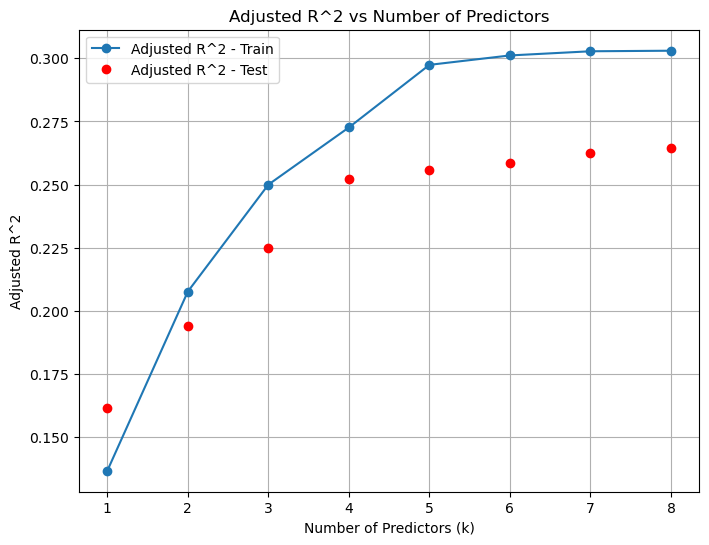

In [44]:
# plot resulting adjusted rsquared vs number of predictors (k=1,2,3,4,5)
# overlay the adjusted rsquared for the test data 
k = [1, 2, 3, 4, 5, 6, 7, 8] 
adjr2_train = [train_yield1.rsquared, train_yield2.rsquared, train_yield3.rsquared, train_yield4.rsquared, train_yield5.rsquared, train_yield6.rsquared, train_yield7.rsquared, train_yield8.rsquared,]


test_yield1 = smf.ols(formula='Yieldacre ~  BasalDAP', data=test).fit()
test_yield2 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand', data=test).fit()
test_yield3 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost', data=test).fit()
test_yield4 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length', data=test).fit()
test_yield5 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length+Harv_hand_rent', data=test).fit()
test_yield6 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length+Harv_hand_rent+StandingWater', data=test).fit()
test_yield7 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length+Harv_hand_rent+StandingWater+CropOrgFYM', data=test).fit()
test_yield8 = smf.ols(formula='Yieldacre ~  BasalDAP + CropCultLand + TransIrriCost+Residue_length+Harv_hand_rent+StandingWater+CropOrgFYM+CropTillageDepth', data=test).fit()
adjr2_test = [test_yield1.rsquared, test_yield2.rsquared, test_yield3.rsquared, test_yield4.rsquared, test_yield5.rsquared, test_yield6.rsquared, test_yield7.rsquared, test_yield8.rsquared,]

df = pd.DataFrame({'k': k, 'adjr2_train': adjr2_train, 'adjr2_test': adjr2_test})

plt.figure(figsize=(8, 6))
plt.plot(df['k'], df['adjr2_train'], label='Adjusted R^2 - Train', marker='o')
plt.plot(df['k'], df['adjr2_test'], 'ro', label='Adjusted R^2 - Test', linestyle='none')


plt.title('Adjusted R^2 vs Number of Predictors')
plt.xlabel('Number of Predictors (k)')
plt.ylabel('Adjusted R^2')
plt.xticks(k) 
plt.legend()
plt.grid(True)
plt.show()

### Forward selection method is applied to feature selections. Comparing the adjusted R^2 value for the 8 models, the model with 5 features is good enough.There is not much improvement reflected on adjusted R^2 when including more features, e.g., 6 or 7 features.

## Tree-Based Models

In [57]:
#X_train = train.drop(['Yieldacre'], axis=1)
X_train= train[['BasalDAP', 'CropCultLand', 'TransIrriCost', 'Residue_length', 'Harv_hand_rent', 'StandingWater', 'CropOrgFYM', 'CropTillageDepth']]
Y_train = train['Yieldacre']

#X_test = test.drop(['Yieldacre'], axis=1)
X_test= test[['BasalDAP', 'CropCultLand', 'TransIrriCost', 'Residue_length', 'Harv_hand_rent', 'StandingWater', 'CropOrgFYM', 'CropTillageDepth']]
Y_test = test['Yieldacre']

best_rmse = float('inf')
seed = 42

# Initialize the Extra Tree and LightGBM models 
extra_trees = ExtraTreesRegressor(n_estimators=100, random_state=seed)
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)

# Train the models
et   = extra_trees.fit(X_train, Y_train)
lgbm = lgbm.fit(X_train, Y_train)


# Make predictions on the validation set
pred_et   = extra_trees.predict(X_test)
pred_lgbm = lgbm.predict(X_test)

# Ensemble Models: simple averaging of predictions
pred_ens  = (pred_et + pred_lgbm) / 2


# Evaluate the ensemble model
#rmse = root_mean_squared_error(np.expm1(Y_test), np.expm1(pred_ens))
rmse = root_mean_squared_error(Y_test, pred_ens)
print(f"Mean Squared Error of Ensemble: {rmse}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 2322, number of used features: 8
[LightGBM] [Info] Start training from score 27.736687
Mean Squared Error of Ensemble: 5.958206503601951


[0.8657646888414987, 0.8591508968667684, 0.8696468586859251, 0.2643070016071709]


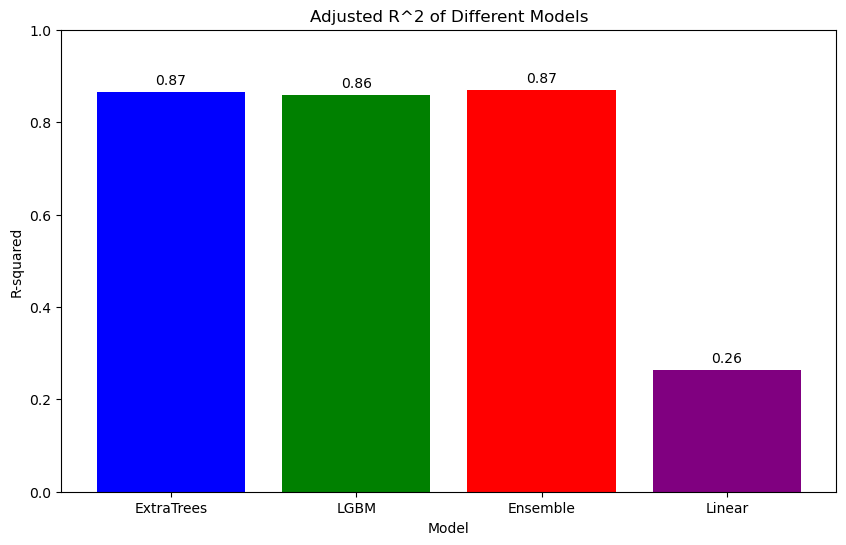

In [74]:
# Calculate R-squared

r2_et = r2_score(Y_test, pred_et)
r2_lgbm = r2_score(Y_test, pred_lgbm)
r2_ensemble = r2_score(Y_test, pred_ens)

models = ['ExtraTrees', 'LGBM', 'Ensemble','Linear']
r2_values = [r2_et,  r2_lgbm, r2_ensemble, test_yield8.rsquared,]
print(r2_values)

#Plotting
fig, ax = plt.figure(figsize=(10, 6)), plt.gca()
bars = ax.bar(models, r2_values, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('Adjusted R^2 of Different Models')
plt.ylim(0, 1)
plt.show()


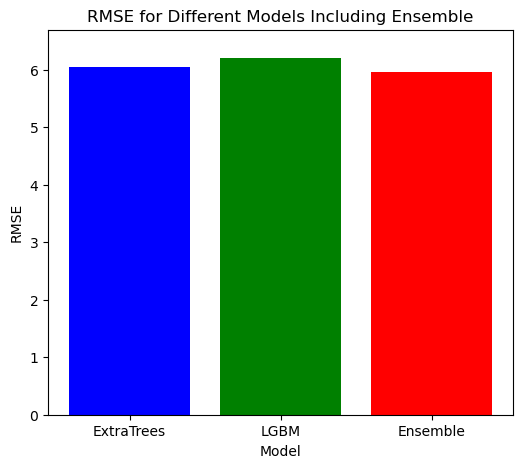

In [70]:
# Comparison of the RMSE
rmse_et = root_mean_squared_error(Y_test, pred_et)
rmse_lgbm = root_mean_squared_error(Y_test, pred_lgbm)
rmse_ensemble = rmse

models = ['ExtraTrees',  'LGBM', 'Ensemble']
rmse_values = [rmse_et, rmse_lgbm, rmse_ensemble]

plt.figure(figsize=(6, 5))
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE for Different Models Including Ensemble')
plt.ylim(0, max(rmse_values)+0.5)
plt.show()

[0.8657646888414987, 0.8591508968667684, 0.8696468586859251, 0.2643070016071709]


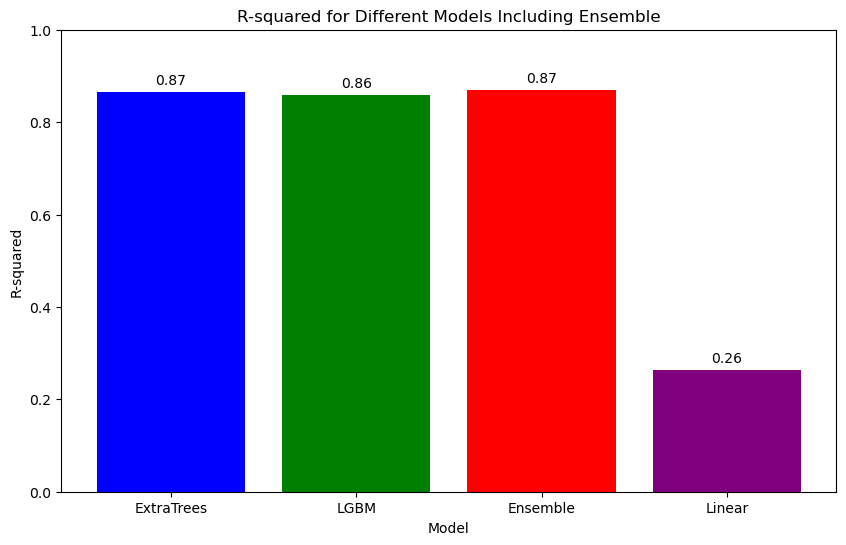

In [ ]:
X_test = test_data.drop(id, axis=1)
predictions_et = et.predict(X_test)
predictions_cb = cb.predict(X_test)
predictions_lgbm = lgbm.predict(X_test)
ensemble_predictions = (predictions_et + predictions_cb + predictions_lgbm) / 3

# Reverse the log-transformation
final_predictions = np.rint(np.expm1(ensemble_predictions))

final_predictions_df = pd.DataFrame(final_predictions, columns=["Yield"])
final_predictions_df = final_predictions_df.reset_index(drop=True)
submission = pd.DataFrame({id: test[id], label_col: final_predictions_df[label_